In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import pandas as pd

# 自定义数据集类
class SensorDataset(Dataset):
    def __init__(self, data_path):
        data = pd.read_csv(data_path).values
        self.X = data[:, :84].astype(np.float32)   # 输入：前84位
        self.y = data[:, -42:].astype(np.float32)   # 输出：后42位真实数据
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 基于1D卷积的自编码器
class Conv1DAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # 编码器：1D卷积提取时间特征
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),  # 输入形状: (batch, 1, 84)
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),  # 输出形状: (batch, 16, 42)
            nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)  # 输出形状: (batch, 32, 21)
        )
        # 解码器：反卷积还原时间特征
        self.decoder = torch.jit.load('best_conv1d_decoder_16_42.pt')
        # 设置为评估模式（禁用 dropout/batch norm 等）
        self.decoder.eval()
    
    def forward(self, x):
        x = x.unsqueeze(1)  # 增加通道维度：(batch, 1, 84)
        encoded = self.encoder(x)
        return encoded

# 训练参数设置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
learning_rate = 0.001
num_epochs = 200

# 加载数据集并划分训练集和验证集
dataset = SensorDataset("log_20250224_0043.csv")  # 替换为你的数据路径
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# 初始化模型、损失函数和优化器
model = Conv1DAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 训练循环
best_val_loss = float('inf')
for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        encoded = model(inputs)
        decoded = model.decoder(encoded)
        outputs = decoded.squeeze(1)  # 移除通道维度：(batch, 42)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    
    # 验证阶段
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            encoded = model(inputs)
            decoded = model.decoder(encoded)
            outputs = decoded.squeeze(1)  # 移除通道维度：(batch, 42)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(val_dataset)
    
    # 保存最佳模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model_scripted = torch.jit.script(model)
        
        # en_in_dim = model.encoder[0].in_channels
        # mid_dim = model.decoder[0].in_channels
        # de_ou_dim = model.decoder[-1].out_features
        
        
        # model_scripted.save(f'best_conv1d_model_{en_in_dim}_{de_ou_dim}.pt')
        # torch.save(model.encoder.state_dict(), f'best_conv1d_encoder_{en_in_dim}_{mid_dim}.pt')
        # torch.save(model.decoder.state_dict(), f'best_conv1d_decoder_{mid_dim}_{de_ou_dim}.pt')
    
    print(f'Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')

# 加载最佳模型进行测试或使用
# model.load_state_dict(torch.load('best_conv1d_model.pth'))

Epoch [1/200] | Train Loss: 0.0195 | Val Loss: 0.0035
Epoch [2/200] | Train Loss: 0.0029 | Val Loss: 0.0022
Epoch [3/200] | Train Loss: 0.0021 | Val Loss: 0.0033
Epoch [4/200] | Train Loss: 0.0018 | Val Loss: 0.0019
Epoch [5/200] | Train Loss: 0.0016 | Val Loss: 0.0019
Epoch [6/200] | Train Loss: 0.0015 | Val Loss: 0.0013
Epoch [7/200] | Train Loss: 0.0015 | Val Loss: 0.0019
Epoch [8/200] | Train Loss: 0.0014 | Val Loss: 0.0011
Epoch [9/200] | Train Loss: 0.0014 | Val Loss: 0.0011
Epoch [10/200] | Train Loss: 0.0013 | Val Loss: 0.0012
Epoch [11/200] | Train Loss: 0.0013 | Val Loss: 0.0010
Epoch [12/200] | Train Loss: 0.0013 | Val Loss: 0.0013
Epoch [13/200] | Train Loss: 0.0013 | Val Loss: 0.0010
Epoch [14/200] | Train Loss: 0.0013 | Val Loss: 0.0014
Epoch [15/200] | Train Loss: 0.0012 | Val Loss: 0.0011
Epoch [16/200] | Train Loss: 0.0012 | Val Loss: 0.0011
Epoch [17/200] | Train Loss: 0.0012 | Val Loss: 0.0011
Epoch [18/200] | Train Loss: 0.0012 | Val Loss: 0.0009
Epoch [19/200] | Tr

In [15]:
encoder_scripted = torch.jit.script(model.encoder)
encoder_scripted.save('best_tuning_conv1d_encoder_1_16.pt')

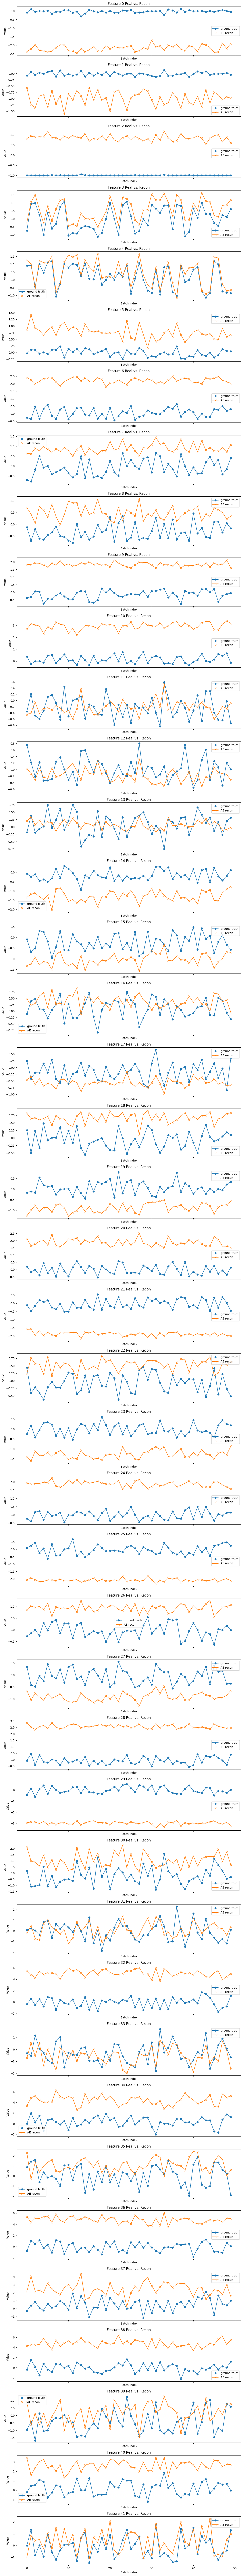

In [17]:
import matplotlib.pyplot as plt
import numpy as np

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.jit.load('best_tuning_conv1d_encoder_1_16.pt')
        self.decoder = torch.jit.load('best_conv1d_decoder_16_42.pt')
        self.encoder.eval()
        self.decoder.eval()
    
    def forward(self, x):
        x = x.unsqueeze(1)  # 增加通道维度：(batch, 1, 84)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.squeeze(1)  # 移除通道维度：(batch, 42)
        return decoded

model = Autoencoder().to(device)

import random
# 随机选择一个批次的数据
random_batch = random.choice(list(val_loader))
x_test, _ = random_batch  # 取出输入数据
x_test = x_test.to(device)

# 只取部分特征进行重构
_x_test = x_test[:,  np.r_[:84]]
real_x_test = x_test[:, -42:]#x_test[:, -42:]  # 真实值

# 进行推理
model.eval()
with torch.no_grad():
    recon_x_test = model(_x_test)

# 转换为 NumPy 方便可视化
_x_test_np = _x_test.cpu().numpy()
real_x_test_np = real_x_test.cpu().numpy()
recon_x_test_np = recon_x_test.cpu().numpy()

# 假设 batch_size 和 feature_dim 已知
batch_size = real_x_test_np.shape[0]  # 批次大小
num_features = real_x_test_np.shape[1]  # 特征数量
num_features = 42

# 创建多个子图，每个子图表示一个元素的 real 和 recon 值
fig, axes = plt.subplots(nrows=num_features, figsize=(12, num_features * 3), sharex=True)

# 确保 axes 是一个可迭代的数组
if num_features == 1:
    axes = [axes]

# 遍历每个特征
for i in range(num_features):
    axes[i].plot(np.arange(50), real_x_test_np[:50, i], label="ground truth", marker='o')
    axes[i].plot(np.arange(50), recon_x_test_np[:50, i], label="AE recon", marker='x')
    axes[i].set_title(f"Feature {i} Real vs. Recon")
    axes[i].set_xlabel("Batch Index")
    axes[i].set_ylabel("Value")
    axes[i].legend()

# 调整布局
plt.tight_layout()
plt.show()
